# Data Preparation

In [1]:
# Import the necessary libraries
import os
import requests
import zipfile
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
from keras.preprocessing.sequence import pad_sequences
from tqdm import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [2]:
# Utilised functions
def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, 'wb') as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

def download_data(data_path):
    toy_data_path = os.path.join(data_path, 'fever_data.zip')
    toy_data_url_id = '1wArZhF9_SHW17WKNGeLmX-QTYw9Zscl1'
    toy_url = 'https://docs.google.com/uc?export=download'

    if not os.path.exists(data_path):
        os.makedirs(data_path)

    if not os.path.exists(toy_data_path):
        print('Downloading FEVER data splits...')
        with requests.Session() as current_session:
            response = current_session.get(toy_url,
                                   params={'id': toy_data_url_id},
                                   stream=True)
        save_response_content(response, toy_data_path)
        print('Download completed!')

        print('Extracting dataset...')
        with zipfile.ZipFile(toy_data_path) as loaded_zip:
            loaded_zip.extractall(data_path)
        print('Extraction completed!')

remove_dict = [', links = no', '-lrb-', '(', '-rrb-', ')', '-lsb-', '[', '-rsb-', ']', '`', '`', '|', '@', ',', ';', ':', '``', '\'\'', 'langpron']

def text_prepare_tokenize(sentence):
    # Only take sentence, remove ID and keywords
    if '\t' in sentence:
      sentence = sentence.split('\t')[1]

    # Transforms given text to lower case
    sentence = sentence.lower()

    # Remove special characters with space
    for key in remove_dict:
        sentence = sentence.replace(key, '')

    # Removes any special character that is not in the good symbols list
    sentence = (re.compile('[^0-9a-z. \t]')).sub('', sentence)
      
    # Removes any left or right spacing
    sentence.strip()

    return nltk.word_tokenize(sentence)

def encode(sentence):
    encoding = []
    for word in sentence:
        if word in word_dict:
            encoding.append(word_dict[word])
        else:
            encoding.append(word_dict['OOV'])
    return encoding

In [3]:
# Download and unzip the dataset
download_data('dataset')

Download completed!
Extracting dataset...
Extraction completed!


In [4]:
# Load the datasets and filter out unwanted columns
train_data = pd.read_csv('/content/dataset/train_pairs.csv')
train_data = train_data[['Claim', 'Evidence', 'Label', 'ID']]

val_data = pd.read_csv('/content/dataset/val_pairs.csv')
val_data = val_data[['Claim', 'Evidence', 'Label', 'ID']]

test_data = pd.read_csv('/content/dataset/test_pairs.csv')
test_data = test_data[['Claim', 'Evidence', 'Label', 'ID']]

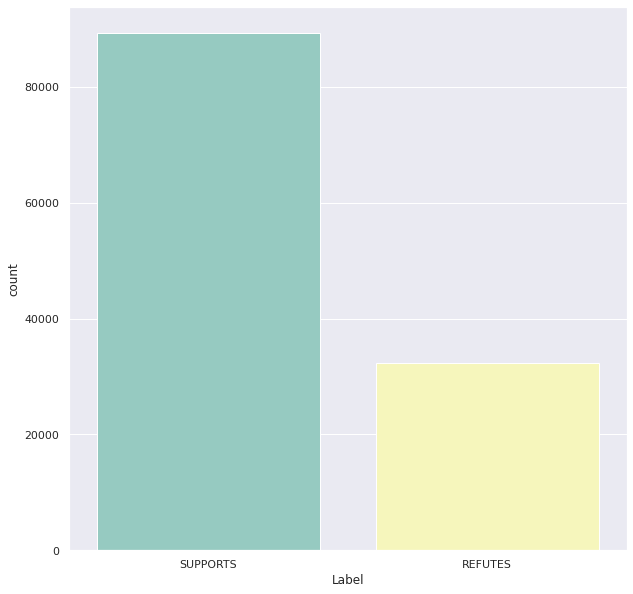

In [5]:
# Breakdown of training data
plt.rcParams['figure.figsize'] = [10, 10]
sns.set_theme(style = 'darkgrid')
sns.countplot(x = 'Label', data = train_data, palette='Set3')
plt.show()

In [6]:
# Tokenise the claims and evidence of the datasets
train_data['Claim'] = train_data['Claim'].progress_apply(lambda txt: text_prepare_tokenize(txt))
train_data['Evidence'] = train_data['Evidence'].progress_apply(lambda txt: text_prepare_tokenize(txt))

val_data['Claim'] = val_data['Claim'].progress_apply(lambda txt: text_prepare_tokenize(txt))
val_data['Evidence'] = val_data['Evidence'].progress_apply(lambda txt: text_prepare_tokenize(txt))

test_data['Claim'] = test_data['Claim'].progress_apply(lambda txt: text_prepare_tokenize(txt))
test_data['Evidence'] = test_data['Evidence'].progress_apply(lambda txt: text_prepare_tokenize(txt))

100%|██████████| 7189/7189 [00:01<00:00, 5004.21it/s]


In [7]:
# Build the word dictionary using the training data
word_dict = {}
word_lst = [np.hstack(train_data['Claim'].values), np.hstack(train_data['Evidence'].values)]
words = np.hstack(word_lst)

# Start from 1 as 0 will be used for encoding the padding
i = 1
for word in words:
    if word not in word_dict:
        word_dict[word] = i
        i += 1

# Add an out-of-vocabulary encoding for words not in the training data
word_dict['OOV'] = len(word_dict)+1

print(f'Number of unique words: {len(word_dict)}')

Number of unique words: 35980


In [8]:
# Encode the claims and evidence of the datasets
train_data['Claim_Tokens'] = train_data['Claim'].apply(encode)
train_data['Evidence_Tokens'] = train_data['Evidence'].apply(encode)

val_data['Claim_Tokens'] = val_data['Claim'].apply(encode)
val_data['Evidence_Tokens'] = val_data['Evidence'].apply(encode)

test_data['Claim_Tokens'] = test_data['Claim'].apply(encode)
test_data['Evidence_Tokens'] = test_data['Evidence'].apply(encode)

In [9]:
# Pad the sequences to the length of the longest sequence with zeros
max_length = 100
print(f'Maximum length of the sequence: {max_length}')

train_data['Claim_Tokens'] = list(pad_sequences(train_data['Claim_Tokens'], maxlen = max_length, padding='post'))
train_data['Evidence_Tokens'] = list(pad_sequences(train_data['Evidence_Tokens'], maxlen = max_length, padding='post'))

val_data['Claim_Tokens'] = list(pad_sequences(val_data['Claim_Tokens'], maxlen = max_length, padding='post'))
val_data['Evidence_Tokens'] = list(pad_sequences(val_data['Evidence_Tokens'], maxlen = max_length, padding='post'))

test_data['Claim_Tokens'] = list(pad_sequences(test_data['Claim_Tokens'], maxlen = max_length, padding='post'))
test_data['Evidence_Tokens'] = list(pad_sequences(test_data['Evidence_Tokens'], maxlen = max_length, padding='post'))

Maximum length of the sequence: 100


In [10]:
# Preview the training dataset
train_data = train_data[['Claim', 'Claim_Tokens', 'Evidence', 'Evidence_Tokens', 'Label', 'ID']]
train_data.head()

,Claim,Claim_Tokens,Evidence,Evidence_Tokens,Label,ID
0,"[chris, hemsworth, appeared, in, a, perfect, g...","[1, 2, 3, 4, 5, 6, 7, 8, 0, 0, 0, 0, 0, 0, 0, ...","[hemsworth, has, also, appeared, in, the, scie...","[2, 15, 533, 3, 4, 46, 2871, 3072, 2100, 94, 7...",SUPPORTS,3
1,"[roald, dahl, is, a, writer, .]","[9, 10, 11, 5, 12, 8, 0, 0, 0, 0, 0, 0, 0, 0, ...","[roald, dahl, ro.ld, dl, ul, dl, 13, september...","[9, 10, 20294, 20295, 20296, 20295, 323, 758, ...",SUPPORTS,7
2,"[roald, dahl, is, a, governor, .]","[9, 10, 11, 5, 13, 8, 0, 0, 0, 0, 0, 0, 0, 0, ...","[roald, dahl, ro.ld, dl, ul, dl, 13, september...","[9, 10, 20294, 20295, 20296, 20295, 323, 758, ...",REFUTES,8
3,"[ireland, has, relatively, lowlying, mountains...","[14, 15, 16, 17, 18, 8, 0, 0, 0, 0, 0, 0, 0, 0...","[the, island, s, geography, comprises, relativ...","[46, 447, 8767, 10171, 3733, 16, 17, 18, 11003...",SUPPORTS,9
4,"[ireland, does, not, have, relatively, lowlyin...","[14, 19, 20, 21, 16, 17, 18, 8, 0, 0, 0, 0, 0,...","[the, island, s, geography, comprises, relativ...","[46, 447, 8767, 10171, 3733, 16, 17, 18, 11003...",REFUTES,10


In [11]:
# Encode the labels as binary values
train_labels = np.array([1 if i == 'SUPPORTS' else 0 for i in train_data['Label']], dtype=np.int32)
val_labels = np.array([1 if i == 'SUPPORTS' else 0 for i in val_data['Label']], dtype=np.int32)
test_labels = np.array([1 if i == 'SUPPORTS' else 0 for i in test_data['Label']], dtype=np.int32)

In [12]:
# Pair up the claim and evidence tokens for training
train_tokens = [np.array(train_data['Claim_Tokens'].to_list(), dtype = np.int32), np.array(train_data['Evidence_Tokens'].to_list(), dtype = np.int32)]
val_tokens = [np.array(val_data['Claim_Tokens'].to_list(), dtype = np.int32), np.array(val_data['Evidence_Tokens'].to_list(), dtype = np.int32)]
test_tokens = [np.array(test_data['Claim_Tokens'].to_list(), dtype = np.int32), np.array(test_data['Evidence_Tokens'].to_list(), dtype = np.int32)]

# Model Definition

In [13]:
# Import the necessary libraries
import gensim.downloader as gloader
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Dropout, Embedding, Concatenate, Add, Average, Dot, Bidirectional, Multiply, Reshape, Flatten, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras import metrics
from keras.backend import reshape

In [14]:
# Download the GloVe embeddings and build an embedding matrix
embedding_dimension = 50
embedding_model = gloader.load("glove-wiki-gigaword-{}".format(embedding_dimension))

embedding_matrix =  [np.zeros((embedding_dimension))]
for word in word_dict.keys() :
    if word in embedding_model.vocab :
        embedding_matrix.append(embedding_model[word])
    else:
        embedding_matrix.append(np.random.uniform(low = -0.05, high = 0.05, size = embedding_dimension))
embedding_matrix = np.array(embedding_matrix)

print(embedding_matrix.shape)

[==================================================] 100.0% 66.0/66.0MB downloaded
(35981, 50)


In [15]:
# Definition of the neural network architecture
def create_model(embedding_matrix, chosen_sentence_embedding = 1, chosen_merge = 1, chosen_cosine = True):

    # Split the input as claim and evidence
    input_claim = Input(shape = max_length, dtype=np.int32)
    input_evidence = Input(shape = max_length, dtype=np.int32)

    # Embedding layer
    embedding_layer = Embedding(
        input_dim = len(word_dict) + 1,
        output_dim = 50,
        weights = [embedding_matrix],
        input_length=100,
        mask_zero = True,
        trainable = False
    )
    claim_embedding = embedding_layer(input_claim)
    evidence_embedding = embedding_layer(input_evidence)

    # Sentence embedding methods
    # Final state of RNN
    if chosen_sentence_embedding == 1:
        _, forward_h, _, backward_h, _ = Bidirectional(LSTM(128, dropout = 0.2, return_state = True))(claim_embedding)
        claim_sentence_embedding = Concatenate()([forward_h, backward_h])
        _, forward_h, _, backward_h, _ = Bidirectional(LSTM(128, dropout = 0.2, return_state = True))(evidence_embedding)
        evidence_sentence_embedding = Concatenate()([forward_h, backward_h])
    
    # Average states of RNN
    elif chosen_sentence_embedding == 2:
        claim_sentence_embedding = GlobalAveragePooling1D()(Bidirectional(LSTM(128, return_sequences = True))(claim_embedding))
        evidence_sentence_embedding = GlobalAveragePooling1D()(Bidirectional(LSTM(128, return_sequences = True))(evidence_embedding))
    
    # MLP
    elif chosen_sentence_embedding == 3:
        claim_embedding = Flatten()(claim_embedding)
        claim_sentence_embedding = Dense(128)(claim_embedding)
        evidence_embedding = Flatten()(evidence_embedding)
        evidence_sentence_embedding = Dense(128)(evidence_embedding)
    
    # Average of word embeddings
    elif chosen_sentence_embedding == 4:
        claim_sentence_embedding = GlobalAveragePooling1D()(claim_embedding)
        evidence_sentence_embedding = GlobalAveragePooling1D()(evidence_embedding)

    # Embedding merging methods
    # Concatenate the embeddings
    if chosen_merge == 1:
        merged_input = Concatenate()([claim_sentence_embedding, evidence_sentence_embedding])
    
    # Sum the embeddings
    elif chosen_merge == 2:
        merged_input = Add()([claim_sentence_embedding, evidence_sentence_embedding])
    
    # Average the embeddings
    elif chosen_merge == 3:
        merged_input = Average()([claim_sentence_embedding, evidence_sentence_embedding])
    
    # Concatenate the cosine similarities
    if chosen_cosine:
        cosine_similarity = Dot(axes = 1, normalize = True)([claim_sentence_embedding, evidence_sentence_embedding])
        merged_input = Concatenate()([merged_input, cosine_similarity])

    # Model architecture
    layer = Dense(256, input_dim = 20, activation = 'relu', kernel_regularizer=regularizers.l2(1e-4))(merged_input)
    dropout = Dropout(0.2)(layer)
    layer = Dense(64, activation = 'relu', kernel_regularizer=regularizers.l2(1e-4))(dropout)
    dropout = Dropout(0.2)(layer)
    out = Dense(1, activation = "sigmoid")(dropout)

    return Model(inputs = [input_claim, input_evidence], outputs = [out])

# Training

In [16]:
# # Train the defined model
# model = create_model(embedding_matrix, chosen_sentence_embedding = 2, chosen_merge = 1, chosen_cosine = True)

# model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 1e-3), metrics = [metrics.AUC()])

# history = model.fit(x = train_tokens, 
#                      y = train_labels, 
#                      batch_size = 128,
#                      epochs = 5, 
#                      callbacks = EarlyStopping(monitor = 'val_loss', patience = 10, restore_best_weights = True),
#                      validation_data = (val_tokens, val_labels))

# # Save the trained model
# model.save('models/model.h5')

# Evaluation

In [17]:
# Download the trained models
!gdown --id 1t1NOS6SQ1tm51AvmJXZexFTlQxirSMrs

# Unzip the trained models
!unzip -q -o models.zip -d models

Downloading...
From: https://drive.google.com/uc?id=1t1NOS6SQ1tm51AvmJXZexFTlQxirSMrs
To: /content/models.zip
100% 88.5M/88.5M [00:01<00:00, 46.0MB/s]


In [18]:
# Import the necessary libraries
from keras.models import load_model
from sklearn.metrics import classification_report
pd.options.mode.chained_assignment = None

In [19]:
# Load the best model
best_model = load_model('/content/models/models/model_21t.h5')

In [20]:
# Get the predictions of the best model using the test tokens
pred_labels = best_model.predict(test_tokens)
pred_labels = np.rint(pred_labels)

In [21]:
# Multi-input classification evaluation
print(classification_report(test_labels, pred_labels, zero_division = 1, target_names = ["REFUTES", "SUPPORTS"]))

              precision    recall  f1-score   support

     REFUTES       0.90      0.50      0.64      3583
    SUPPORTS       0.66      0.95      0.77      3606

    accuracy                           0.72      7189
   macro avg       0.78      0.72      0.71      7189
weighted avg       0.78      0.72      0.71      7189



In [22]:
# Claim verification evaluation
majority_voting = pd.DataFrame(columns = ['ID', 'True', 'Pred'])
majority_voting['ID'] = pd.unique(test_data['ID'])

predictions =  pd.DataFrame(columns = ['ID', 'Label'])
predictions["Label"] = [item for sublist in pred_labels for item in sublist]
predictions['ID'] = test_data['ID']

for id in majority_voting['ID']:
  
    # Get the true labels
    majority_voting['True'][majority_voting['ID'] == id] = test_data['Label'][test_data['ID'] == id].iloc[0]

    # Get all the predicted label given an id/claim
    labels = predictions[predictions['ID'] == id]

    # Implement majority vote
    if(len(labels[labels['Label'] == 1]) > len(labels[labels['Label'] == 0])):  
        majority_voting['Pred'][majority_voting['ID'] == id] = 'SUPPORTS'
    else:
        majority_voting['Pred'][majority_voting['ID'] == id] = 'REFUTES'

print(classification_report(majority_voting['True'], majority_voting['Pred'], zero_division = 1))

              precision    recall  f1-score   support

     REFUTES       0.90      0.51      0.65      3304
    SUPPORTS       0.66      0.95      0.78      3309

    accuracy                           0.73      6613
   macro avg       0.78      0.73      0.71      6613
weighted avg       0.78      0.73      0.71      6613



# Comments

In this assignment, a fact checking task was solved by training a classifier on a set of sentence embeddings.  The claims and their evidence are first cleaned and encoded as sentence embeddings. Finally, a classifier is trained on these embeddings to predict if a claim is supported or rejected.  Results show that the best approach achieves an AUC of 85% and F1-score of 71%.

The model uploaded for the evaluation is the best model, but it can be changed.
Not all model are pre-trained and they are named in the following way: *model_abc*

a
*  1 -> RNN final state
*  2 -> RNN average states
*  3 -> Multilayer Perceptron
*  4 -> Bag of Vectors

b
*  1 -> Concatenation
*  2 -> Sum
*  3 -> Mean

c
* t -> cosine similarity concateneted
* f -> cosine similarity not concateneted